In [116]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu


def resection_with_2_known_points(point1, point2, measures_first_point, measures_second_point):
    print(measures_first_point[0])
    station_z = ((point1[2] + measures_first_point[2]*np.sin(measures_first_point[0]-np.pi/2)) + (point2[2] + measures_second_point[2]*np.sin(measures_second_point[0]-np.pi/2)))/2
    
    # find the position of the total station using the intersection of 2 circles given by the measurements of the prism position.
    radius_1 = (measures_first_point[2]*np.cos(measures_first_point[0]-np.pi/2))
    radius_2 = (measures_second_point[2]*np.cos(measures_second_point[0]-np.pi/2))
    
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    
    # find the y value based on the intersection of 2 circles aligned in x (same value of x)
    x = (radius_1**2 - radius_2**2 - point1[0]**2 + point2[0]**2)/(2*delta_x)
    
    # find the possible values of x based on the quadratic formula and the circle formula knowing y
    # A_1 = 1
    # B_1 = -2*point1[0]
    # C_1 = point1[0]**2 + y**2 + point1[1]**2 - 2*y*point1[1] - radius_1**2
    
    y_1_1 = np.sqrt( -x**2 - point1[0]**2 + 2*x*point1[0] + radius_1**2)
    
    y_2_1 = -np.sqrt( -x**2 - point1[0]**2 + 2*x*point1[0] + radius_1**2)
    
    # A_2 = 1
    # B_2 = -2*point2[0]
    # C_2 = point2[0]**2 + y**2 + point2[1]**2 - 2*y*point2[1] - radius_2**2
    
    y_1_2 = np.sqrt( -x**2 - point2[0]**2 + 2*x*point2[0] + radius_2**2)
    
    y_2_2 = -np.sqrt( -x**2 - point2[0]**2 + 2*x*point2[0] + radius_2**2)
    
#     print("x_1: ")
#     print(x_1_1)
#     print(x_1_2)
#     print(np.mean([x_1_1, x_1_2]))
    
#     print("x_2: ")
#     print(x_2_1)
#     print(x_2_2)
#     print(np.mean([x_2_1, x_2_2]))
    
    station_pos_complete_1 = np.array([x, np.mean([y_1_1, y_1_2]), station_z, 0, 0, 0])   
    station_pos_complete_2 = np.array([x, np.mean([y_2_1, y_2_2]), station_z, 0, 0, 0])
    
    return [station_pos_complete_1, station_pos_complete_2]

def calculate_tf_angle(point1, ref_point, station_pose):
    T = np.identity(4)
    dx1 = point1[0] - station_pose[0]
    dy1 = point1[1] - station_pose[1]
    dxref = ref_point[0] - station_pose[0]
    dyref = ref_point[1] - station_pose[1]
    if dyref >= 0:
        if dx1 <= 0:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, abs(dx1))
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(np.pi - theta1 - theta2)
            else:
                theta1 = np.arctan2(abs(dy1), abs(dx1))
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(np.pi + theta1 - theta2)
        else:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, dx1)
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(theta1 - theta2)
            else:
                theta1 = np.arctan2(abs(dy1), dx1)
                theta2 = np.arctan2(dyref, dxref)
                thetaR = -(theta2 + theta1)
    else:
        if dx1 <= 0:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, abs(dx1))
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = (np.pi + theta1 - theta2)
            else:
                theta1 = np.arctan2(abs(dy1), abs(dx1))
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = (np.pi - theta1 - theta2)
        else:
            if dy1 >= 0:
                theta1 = np.arctan2(dy1, dx1)
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = -(theta1 + theta2)
            else:
                theta1 = np.arctan2(abs(dy1), dx1)
                theta2 = np.arctan2(abs(dyref), dxref)
                thetaR = -(theta2 - theta1)
    Rot_r = np.array([[np.cos(thetaR), -np.sin(thetaR), 0],
                 [np.sin(thetaR), np.cos(thetaR), 0],
                 [0, 0, 1]])
    T[0:3,0:3]=Rot_r
    return T

def calculate_tf_angle_using_scalar_product(measured_points, reference_points, calib_index):
    angle = 0
    if calib_index==0:
        measured_line = measured_points[0][:3] - measured_points[1][:3]
        reference_line = reference_points[0] - reference_points[1]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[0][0]<reference_points[0][0]:
            angle = -angle
    elif calib_index==1:
        measured_line = measured_points[0][:3] - measured_points[2][:3]
        reference_line = reference_points[0] - reference_points[2]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[0][0]>reference_points[0][0]:
            angle = -angle
    elif calib_index==2:
        measured_line = measured_points[0][:3] - measured_points[3][:3]
        reference_line = reference_points[0] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[0][0]>reference_points[0][0]:
            angle = -angle
    elif calib_index==3:
        measured_line = measured_points[1][:3] - measured_points[2][:3]
        reference_line = reference_points[1] - reference_points[2]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[1][0]>reference_points[1][0]:
            angle = -angle
    elif calib_index==4:
        measured_line = measured_points[1][:3] - measured_points[3][:3]
        reference_line = reference_points[1] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[1][0]>reference_points[1][0]:
            angle = -angle
    elif calib_index==5:
        measured_line = measured_points[2][:3] - measured_points[3][:3]
        reference_line = reference_points[2] - reference_points[3]
        angle = np.arccos(np.clip(np.dot(reference_line, measured_line)/(np.linalg.norm(measured_line)*np.linalg.norm(reference_line)), -1.0, 1.0))
        if measured_points[2][0]<reference_points[2][0]:
            angle = -angle
    T = np.identity(4)
    Rot_r = np.array([[np.cos(angle), -np.sin(angle), 0],
                 [np.sin(angle), np.cos(angle), 0],
                 [0, 0, 1]])
    T[0:3,0:3]=Rot_r
    return T

In [124]:
%matplotlib notebook

pilier_A = np.array([0, 0, 100])
pilier_B = np.array([np.sqrt(181.016**2 - 0.323**2), 0, 100 + 0.323])
pilier_C = np.array([np.sqrt(363.492**2 - 1.038**2), 0, 100 + 1.038])
pilier_D = np.array([np.sqrt(548.578**2 - 2.374**2), 0, 100 + 2.374])

liste_piliers = [pilier_A, pilier_B, pilier_C, pilier_D]

# Read markers file of grand axe and show them
tfu = importlib.reload(tfu)
ttfu = importlib.reload(ttfu)

file_name = './data/total_station/20220711/theodolite_reference_prisms_geomatic.txt'

raw_1, raw_2, raw_3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = ttfu.read_marker_file_raw_data(file_name)
station_1_pos1 = []
station_1_pos2 = []
station_2_pos1 = []
station_2_pos2 = []
station_3_pos1 = []
station_3_pos2 = []

for i in range(len(liste_piliers)):
    for j in range(i+1, len(liste_piliers)):
        print(i,j)
        possible_poses_station_1 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_1[i], raw_1[j])
        for pose, station in zip(possible_poses_station_1, [station_1_pos1, station_1_pos2]):
            station.append(pose)
        possible_poses_station_2 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_2[i], raw_2[j])
        for pose, station in zip(possible_poses_station_2, [station_2_pos1, station_2_pos2]):
            station.append(pose)
        possible_poses_station_3 = resection_with_2_known_points(liste_piliers[i], liste_piliers[j], raw_3[i], raw_3[j])
        for pose, station in zip(possible_poses_station_3, [station_3_pos1, station_3_pos2]):
            station.append(pose)

#station_1_pos1, station_1_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_1[0], raw_1[1])
#station_2_pos1, station_2_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_2[0], raw_2[1])
#station_3_pos1, station_3_pos2 = resection_with_2_known_points(pilier_D, pilier_C, raw_3[0], raw_3[1])
print("Sation 1:")
print("possible position 1: ", station_1_pos1)
print("possible position 2: ", station_1_pos2)
print("Station 2:")
print("possible position 1: ", station_2_pos1)
print("possible position 2: ", station_2_pos2)
print("Station 3:")
print("possible position 1: ", station_3_pos1)
print("possible position 2: ", station_3_pos2)

0 1
1.5746
1.5736
1.57371
0 2
1.5746
1.5736
1.57371
0 3
1.5746
1.5736
1.57371
1 2
1.57784
1.57523
1.57549
1 3
1.57784
1.57523
1.57549
2 3
1.57149
1.56761
1.56804
Sation 1:
possible position 1:  [array([290.2034748 ,  12.73803826, 101.10110949,   0.        ,
         0.        ,   0.        ]), array([290.21014983,  12.58504437, 101.09724208,   0.        ,
         0.        ,   0.        ]), array([290.21918927,  12.37483663, 101.1036449 ,   0.        ,
         0.        ,   0.        ]), array([290.21677148,  12.6235404 , 101.09344423,   0.        ,
         0.        ,   0.        ]), array([290.22692839,  12.53536513, 101.09984704,   0.        ,
         0.        ,   0.        ]), array([290.2369422 ,  12.74006805, 101.09597963,   0.        ,
         0.        ,   0.        ])]
possible position 2:  [array([290.2034748 , -12.73803826, 101.10110949,   0.        ,
         0.        ,   0.        ]), array([290.21014983, -12.58504437, 101.09724208,   0.        ,
         0.        

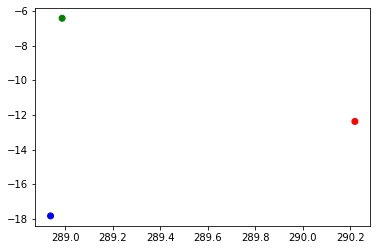

In [125]:
%matplotlib inline
plt.figure()
plt.scatter([station_1_pos2[2][0], station_2_pos2[2][0], station_3_pos2[2][0]],[station_1_pos2[2][1], station_2_pos2[2][1], station_3_pos2[2][1]],c=['r', 'g', 'b'])

[0.20619522751237504, 0.15936670189174576, 0.36550939246772307, 0.20059705838746206, 0.16417687174762183, 0.36469591501582593]
[0.20371781673661996, 0.1573127507773729, 0.360972441938287, 0.20462968945713356, 0.16041842495227404, 0.3648752322962922]
Median error for the control points:  203.396 mm
Median error for the validation points:  204.174 mm


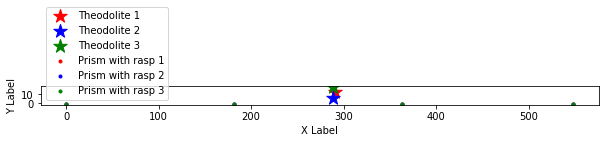

[0.0023484404365490263, 0.003328927925537073, -0.004054459800670429, -0.0027361279139768158]
[0.2061727938432032, 0.20367957358593536, 0.20457365401785044, 0.20056928583071976]
[-0.0019328102038542738, -0.002120942868913289, 0.0025477921486043442, 0.0019118104237207945]
[0.0032250442579879746, 0.0028954576558533063, -0.006766139050682796, -0.004247160126169547]
[-0.15933302723428788, -0.15728609482491862, -0.16026147310082628, -0.1641209819498073]
[-0.0005754943477143115, 4.7506143786790744e-05, -0.002133229023883132, 0.0005568945400824532]
[0.0008766038214389482, -0.0004334702696837667, -0.0027116792500123665, -0.001511032212192731]
[-0.3655058210774911, -0.360965668410854, -0.3648351271186767, -0.36469026778052704]
[0.0013573158561399623, 0.00216844901270008, -0.004681021172487476, -0.0013549158836383413]
-0.012154422671414977
-0.012154422671414977
0.0
[0.005337969689776401, 0.003594939814178133, -0.005065799195335785, -0.006827937668276718]
[-0.3548386030397044, -0.34559861849819384

In [126]:
%matplotlib inline

tfu = importlib.reload(tfu)
# choose which line is right for each total station in this section (the correct position is the first or the 2nd found with the resection)
# for i in range(len(station_1_pos1)):
#     Tf1 = tfu.tf_from_pose_roll_pitch_yaw(station_1_pos1[i])
#     Tf12 = ttfu.tf_from_pose_roll_pitch_yaw(station_1_pos2[i])

#     Tf2 = tfu.tf_from_pose_roll_pitch_yaw(station_2_pos1[i])
#     Tf22 = ttfu.tf_from_pose_roll_pitch_yaw(station_2_pos2[i])

#     Tf3 = tfu.tf_from_pose_roll_pitch_yaw(station_3_pos1[i])
#     Tf32 = ttfu.tf_from_pose_roll_pitch_yaw(station_3_pos2[i])
#     print(Tf1)
#     print(Tf12)
#     print(Tf2)
#     print(Tf22)
#     print(Tf3)
#     print(Tf32)
TF1 = []
TF2 = []
TF3 = []
tp1 = []
tp2 = []
tp3 = []
TR1 = []
TR2 = []
TR3 = []

# for i in range(len(station_1_pos2)):
i = 2
TF1.append(tfu.tf_from_pose_roll_pitch_yaw(station_1_pos1[i]))
TF2.append(tfu.tf_from_pose_roll_pitch_yaw(station_2_pos1[i]))
TF3.append(tfu.tf_from_pose_roll_pitch_yaw(station_3_pos1[i]))
# print(TF1)
# print(TF2)
# print(TF3)
tp1.append(TF1[0]@trimble_1)
tp2.append(TF2[0]@trimble_2)
tp3.append(TF3[0]@trimble_3)
tp1[0] = tp1[0].T
tp2[0] = tp2[0].T
tp3[0] = tp3[0].T

TR1.append(calculate_tf_angle_using_scalar_product(tp1[0], liste_piliers, i))
TF1[0] = TF1[0]@TR1[0]
tp1[0] = TF1[0]@trimble_1
tp1[0] = tp1[0].T

TR2.append(calculate_tf_angle_using_scalar_product(tp2[0], liste_piliers, i))
TF2[0] = TF2[0]@TR2[0]
tp2[0] = TF2[0]@trimble_2
tp2[0] = tp2[0].T

TR3.append(calculate_tf_angle_using_scalar_product(tp3[0], liste_piliers, i))
TF3[0] = TF3[0]@TR3[0]
tp3[0] = TF3[0]@trimble_3
tp3[0] = tp3[0].T
        

error_validation_points = []
error_control_points = []
# counter = 0
# for i,j,k in zip(tp1[0],tp2[0],tp3[0]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         #print("i: ", np.round(i, 2))
#         #print("j: ", np.round(j, 2))
#         #print("k: ", np.round(k, 2))
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter < 2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[1],tp2[1],tp3[1]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==0 or counter==2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1
error_12_x = []
error_12_y = []
error_12_z = []
error_13_x = []
error_13_y = []
error_13_z = []
error_23_x = []
error_23_y = []
error_23_z = []
error_1_x = []
error_1_y = []
error_1_z = []
error_2_x = []
error_2_y = []
error_2_z = []
error_3_x = []
error_3_y = []
error_3_z = []
counter = 0
for i,j,k in zip(tp1[0],tp2[0],tp3[0]):
        #print("i: ", i, "j: ", j, "k: ", k)
        dist_12 = np.linalg.norm(i-j)
        dist_13 = np.linalg.norm(i-k)
        dist_23 = np.linalg.norm(k-j)
        if counter==0 or counter==3:
            error_control_points.append(dist_12)
            error_control_points.append(dist_13)
            error_control_points.append(dist_23)
        else:
            error_validation_points.append(dist_12)
            error_validation_points.append(dist_13)
            error_validation_points.append(dist_23)
        error_12_x.append(i[0]-j[0])
        error_12_y.append(i[1]-j[1])
        error_12_z.append(i[2]-j[2])
        error_13_x.append(i[0]-k[0])
        error_13_y.append(i[1]-k[1])
        error_13_z.append(i[2]-k[2])
        error_23_x.append(j[0]-k[0])
        error_23_y.append(j[1]-k[1])
        error_23_z.append(j[2]-k[2])
        error_1_x.append(i[0]-liste_piliers[counter][0])
        error_1_y.append(i[1]-liste_piliers[counter][1])
        error_1_z.append(i[2]-liste_piliers[counter][2])
        error_2_x.append(j[0]-liste_piliers[counter][0])
        error_2_y.append(j[1]-liste_piliers[counter][1])
        error_2_z.append(j[2]-liste_piliers[counter][2])
        error_3_x.append(k[0]-liste_piliers[counter][0])
        error_3_y.append(k[1]-liste_piliers[counter][1])
        error_3_z.append(k[2]-liste_piliers[counter][2])
        counter += 1

# counter = 0
# for i,j,k in zip(tp1[3],tp2[3],tp3[3]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==1 or counter==2:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[4],tp2[4],tp3[4]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==1 or counter==3:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

# counter = 0
# for i,j,k in zip(tp1[5],tp2[5],tp3[5]):
#         #print("i: ", i, "j: ", j, "k: ", k)
#         dist_12 = np.linalg.norm(i-j)
#         dist_13 = np.linalg.norm(i-k)
#         dist_23 = np.linalg.norm(k-j)
#         if counter==2 or counter==3:
#             error_control_points.append(dist_12)
#             error_control_points.append(dist_13)
#             error_control_points.append(dist_23)
#         else:
#             error_validation_points.append(dist_12)
#             error_validation_points.append(dist_13)
#             error_validation_points.append(dist_23)
#         counter += 1

print(error_control_points)
print(error_validation_points)
print("Median error for the control points: ", round(np.median(error_control_points)*1000, 3), "mm")
print("Median error for the validation points: ", round(np.median(error_validation_points)*1000, 3), "mm")
for i in range(len(TF1)):
    tfu.plot_trajectories_prism(3, tp1[i].T, tp2[i].T, tp3[i].T, TF1[i], TF2[i], TF3[i], 0, 0,"example.pdf",1)

print(error_12_x)
print(error_12_y)
print(error_12_z)
print(error_13_x)
print(error_13_y)
print(error_13_z)
print(error_23_x)
print(error_23_y)
print(error_23_z)
trimble_1 = trimble_1.T
print(np.linalg.norm(tp1[0][0]-tp1[0][3])-548.578)
print(np.linalg.norm(trimble_1[0] - trimble_1[3])-548.578)
print(np.linalg.norm(liste_piliers[0]-liste_piliers[3])-548.578)
print(error_1_x)
print(error_1_y)
print(error_1_z)
print(error_2_x)
print(error_2_y)
print(error_2_z)
print(error_3_x)
print(error_3_y)
print(error_3_z)

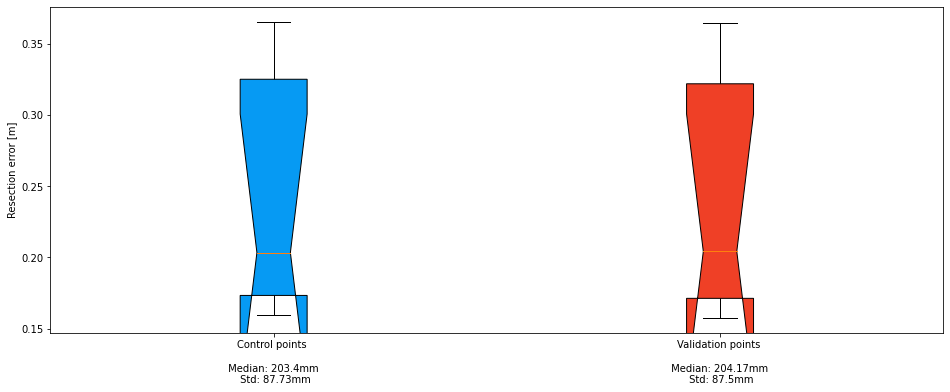

In [127]:
fig = plt.figure(figsize =(16, 6))
ax = fig.add_subplot(111)

box = ax.boxplot([error_control_points, error_validation_points], notch=True, patch_artist=True, vert = 1, showfliers=False, showmeans=False)
plt.xticks([1, 2], ["Control points \n\n Median: "+str(round(np.median(error_control_points)*1000,2))+"mm \n Std: "+str(round(np.std(error_control_points)*1000,2))+"mm",
                          "Validation points \n\n Median: "+str(round(np.median(error_validation_points)*1000,2))+"mm \n Std: "+str(round(np.std(error_validation_points)*1000,2))+"mm"])
colors_box = ['#069AF3', '#EF4026']

for patch, color in zip(box['boxes'], colors_box):
    patch.set_facecolor(color)
        
ax.set_ylabel("Resection error [m]")
plt.show()
#fig.savefig("./figs/new_resection_datasets_prior_only-f-2-1-1-1-6-1-L.jpg")

In [128]:
for i in range(len(station_1_pos2)):
    print(station_1_pos2[i] - station_2_pos2[i])
    print(station_1_pos2[i] - station_3_pos2[i])
    print(station_2_pos2[i] - station_3_pos2[i])

[ 1.23188969 -5.71709961  0.29457026  0.          0.          0.        ]
[1.2786394  5.29055538 0.26111631 0.         0.         0.        ]
[ 0.04674971 11.00765499 -0.03345394  0.          0.          0.        ]
[ 1.23236226 -5.82421083  0.29222954  0.          0.          0.        ]
[1.28075451 5.37032308 0.26220118 0.         0.         0.        ]
[ 0.04839225 11.19453391 -0.03002836  0.          0.          0.        ]
[ 1.23344966 -5.96290408  0.29256143  0.          0.          0.        ]
[1.28216608 5.45736251 0.26086852 0.         0.         0.        ]
[ 0.04871642 11.42026659 -0.03169291  0.          0.          0.        ]
[ 1.23283104 -5.79523416  0.29231555  0.          0.          0.        ]
[1.28285271 5.35060068 0.26188238 0.         0.         0.        ]
[ 0.05002166 11.14583485 -0.03043318  0.          0.          0.        ]
[ 1.23421792 -5.84717259  0.29264745  0.          0.          0.        ]
[1.28390291 5.38401283 0.26054972 0.         0.         0.    